In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Recurrent Neural Networks (RNNs)
<p>RNNs are a class of neural networks designed to process sequential data, where the order of elements matters (e.g., text, speech, time series)</p>
<p>Key Idea: RNNs have a "memory" or "hidden state" that captures information about previous elements in the sequence, influencing the processing of current elements. This is achieved by having recurrent connections (loops) in the network.</p>

In [108]:
def generate_simple_data(n_samples=500):
    """
    Generate simple synthetic data - a combination of sine wave and linear trend
    This is easier to understand and visualize
    """
    x = torch.linspace(0, 4*torch.pi, n_samples)
    
    # Simple pattern: sine wave + small linear trend + minimal noise
    data = torch.sin(x) + 0.1*x + 0.05*torch.randn(n_samples)
    
    return data

raw_data = generate_simple_data(n_samples=400)

In [109]:
raw_data[:5]

tensor([0.0635, 0.0395, 0.0329, 0.0885, 0.1071])

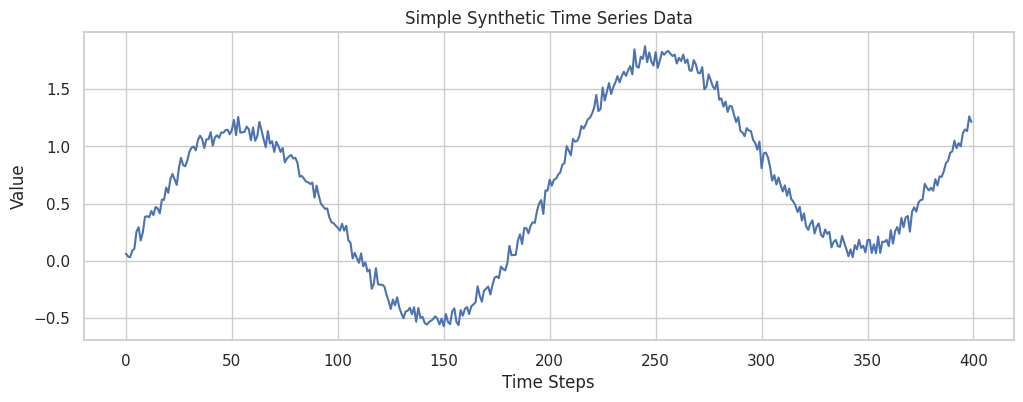

In [110]:
plt.figure(figsize=(12, 4))
plt.plot(raw_data)
plt.title('Simple Synthetic Time Series Data')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [111]:
print(f"Generated {len(raw_data)} data points")
print(f"Data range: {raw_data.min():.3f} to {raw_data.max():.3f}")

Generated 400 data points
Data range: -0.570 to 1.876


In [112]:
def create_sequences(data, seq_length):
    """
    Create sequences for RNN training
    
    Returns:
        X: Input sequences
        y: Target values (next value after each sequence)
    """
    X, y = [], []
    
    for i in range(len(data) - seq_length):
        # Input sequence
        seq_x = data[i:i + seq_length]
        # Target (next single value)
        seq_y = data[i + seq_length]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

# Parameters
SEQUENCE_LENGTH = 10 

In [113]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(raw_data.reshape(-1, 1)).flatten()

In [114]:
X, y = create_sequences(normalized_data, SEQUENCE_LENGTH)

In [115]:
X[:5], y[:5], X.shape, y.shape

(array([[0.25912093, 0.24933768, 0.24663442, 0.26935479, 0.27698005,
         0.33777476, 0.35363617, 0.30628734, 0.3353776 , 0.39095876],
        [0.24933768, 0.24663442, 0.26935479, 0.27698005, 0.33777476,
         0.35363617, 0.30628734, 0.3353776 , 0.39095876, 0.39286794],
        [0.24663442, 0.26935479, 0.27698005, 0.33777476, 0.35363617,
         0.30628734, 0.3353776 , 0.39095876, 0.39286794, 0.38931857],
        [0.26935479, 0.27698005, 0.33777476, 0.35363617, 0.30628734,
         0.3353776 , 0.39095876, 0.39286794, 0.38931857, 0.41186431],
        [0.27698005, 0.33777476, 0.35363617, 0.30628734, 0.3353776 ,
         0.39095876, 0.39286794, 0.38931857, 0.41186431, 0.39696955]]),
 array([0.39286794, 0.38931857, 0.41186431, 0.39696955, 0.42576299]),
 (390, 10),
 (390,))

In [116]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Training set: X=(312, 10), y=(312,)
Test set: X=(78, 10), y=(78,)


In [117]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # Forward pass through RNN
        rnn_out, _ = self.rnn(x, h0)
        
        # Take the output from the last time step
        last_output = rnn_out[:, -1, :]
        
        # Pass through final linear layer
        output = self.fc(last_output)
        
        return output

In [118]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        
        return output

In [119]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        gru_out, _ = self.gru(x, h0)
        last_output = gru_out[:, -1, :]
        output = self.fc(last_output)
        
        return output

In [120]:
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1) 
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)


In [121]:
BATCH_SIZE = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [122]:
def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.01):
    """
    Train the RNN model
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    print(f"Training {model.__class__.__name__}...")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                test_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.6f}, '
                  f'Test Loss: {avg_test_loss:.6f}')
    
    return train_losses, test_losses

In [123]:
rnn_model = SimpleRNN(input_size=1, hidden_size=32, num_layers=1, output_size=1)
lstm_model = SimpleLSTM(input_size=1, hidden_size=32, num_layers=1, output_size=1)
gru_model = SimpleGRU(input_size=1, hidden_size=32, num_layers=1, output_size=1)

In [124]:
# Train RNN model
rnn_train_losses, rnn_test_losses = train_model(rnn_model, train_loader, test_loader, num_epochs=30)


Training SimpleRNN...
Total parameters: 1153
Epoch [10/30], Train Loss: 0.000900, Test Loss: 0.000797
Epoch [20/30], Train Loss: 0.000999, Test Loss: 0.000705
Epoch [30/30], Train Loss: 0.001074, Test Loss: 0.001159


In [125]:
# Train LSTM and GRU
lstm_train_losses, lstm_test_losses = train_model(lstm_model, train_loader, test_loader, num_epochs=30)

gru_train_losses, gru_test_losses = train_model(gru_model, train_loader, test_loader, num_epochs=30)


Training SimpleLSTM...
Total parameters: 4513
Epoch [10/30], Train Loss: 0.001160, Test Loss: 0.000936
Epoch [20/30], Train Loss: 0.000778, Test Loss: 0.001164
Epoch [30/30], Train Loss: 0.000926, Test Loss: 0.001538
Training SimpleGRU...
Total parameters: 3393
Epoch [10/30], Train Loss: 0.000816, Test Loss: 0.000739
Epoch [20/30], Train Loss: 0.001179, Test Loss: 0.000775
Epoch [30/30], Train Loss: 0.000876, Test Loss: 0.000654


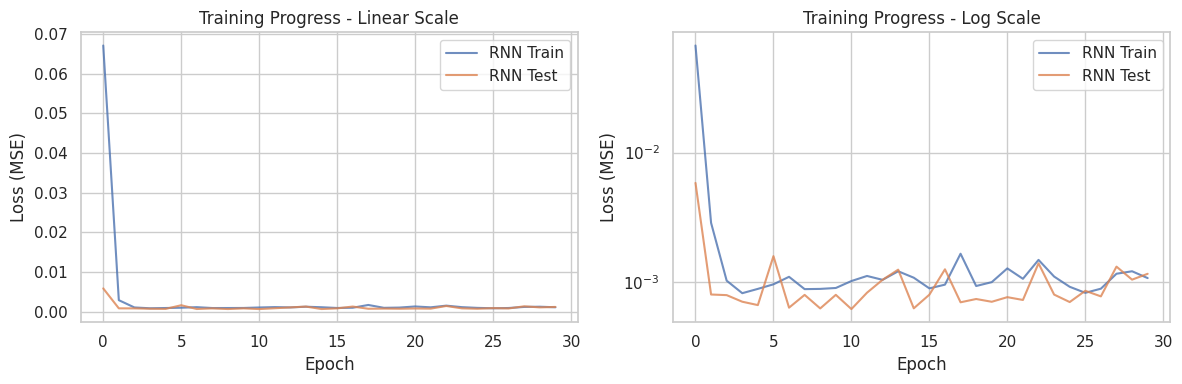

In [136]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rnn_train_losses, label='RNN Train', alpha=0.8)
plt.plot(rnn_test_losses, label='RNN Test', alpha=0.8)
# plt.plot(lstm_train_losses, label='LSTM Train', alpha=0.8)
# plt.plot(lstm_test_losses, label='LSTM Test', alpha=0.8)
# plt.plot(gru_train_losses, label='GRU Train', alpha=0.8)
# plt.plot(gru_test_losses, label='GRU Test', alpha=0.8)
plt.title('Training Progress - Linear Scale')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rnn_train_losses, label='RNN Train', alpha=0.8)
plt.plot(rnn_test_losses, label='RNN Test', alpha=0.8)
# plt.plot(lstm_train_losses, label='LSTM Train', alpha=0.8)
# plt.plot(lstm_test_losses, label='LSTM Test', alpha=0.8)
# plt.plot(gru_train_losses, label='GRU Train', alpha=0.8)
# plt.plot(gru_test_losses, label='GRU Test', alpha=0.8)
plt.title('Training Progress - Log Scale')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

In [139]:
def evaluate_model(model, X_test, y_test, scaler, model_name="Model"):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).squeeze().numpy()
    
    # Denormalize predictions and actual values
    y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()
    predictions_actual = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    mse = np.mean((y_test_actual - predictions_actual) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test_actual - predictions_actual))
    
    print(f"{model_name} Performance:")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    
    return predictions_actual, y_test_actual

In [140]:
rnn_pred, y_actual = evaluate_model(rnn_model, X_test_tensor, y_test_tensor, scaler, "Simple RNN")
print()
lstm_pred, _ = evaluate_model(lstm_model, X_test_tensor, y_test_tensor, scaler, "LSTM")
print()
gru_pred, _ = evaluate_model(gru_model, X_test_tensor, y_test_tensor, scaler, "GRU")

Simple RNN Performance:
  MSE: 0.006825
  RMSE: 0.082614
  MAE: 0.069826

LSTM Performance:
  MSE: 0.009287
  RMSE: 0.096368
  MAE: 0.079140

GRU Performance:
  MSE: 0.003906
  RMSE: 0.062502
  MAE: 0.052736


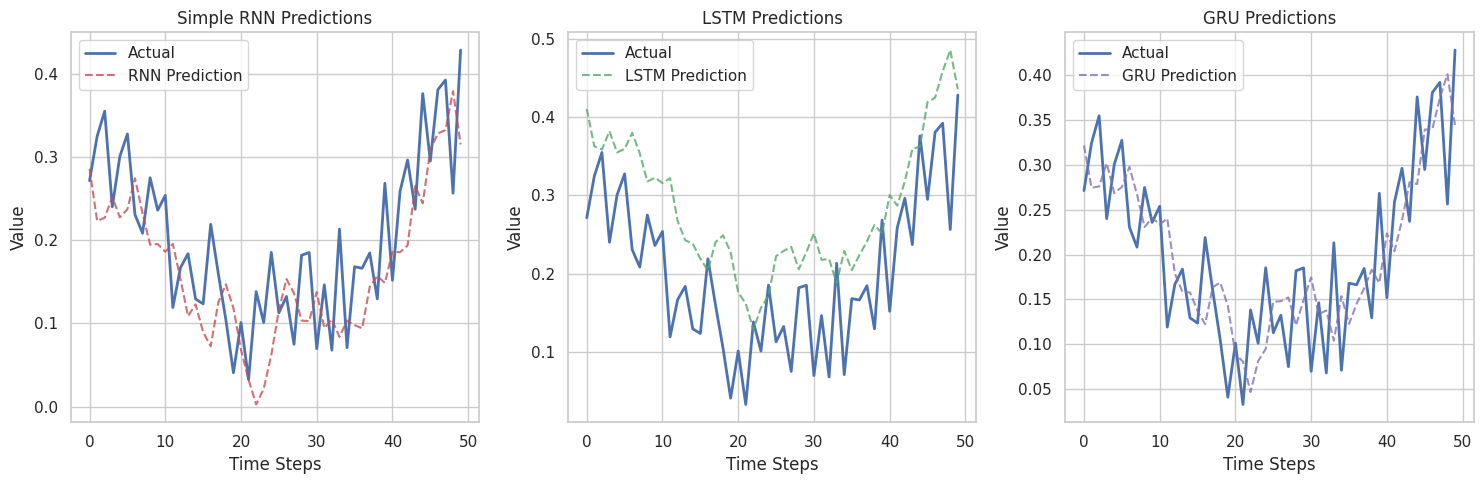

In [141]:
plt.figure(figsize=(15, 5))

# Show first 50 test points for better visibility
n_points = 50

plt.subplot(1, 3, 1)
plt.plot(y_actual[:n_points], 'b-', label='Actual', linewidth=2)
plt.plot(rnn_pred[:n_points], 'r--', label='RNN Prediction', alpha=0.8)
plt.title('Simple RNN Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(y_actual[:n_points], 'b-', label='Actual', linewidth=2)
plt.plot(lstm_pred[:n_points], 'g--', label='LSTM Prediction', alpha=0.8)
plt.title('LSTM Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(y_actual[:n_points], 'b-', label='Actual', linewidth=2)
plt.plot(gru_pred[:n_points], 'm--', label='GRU Prediction', alpha=0.8)
plt.title('GRU Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

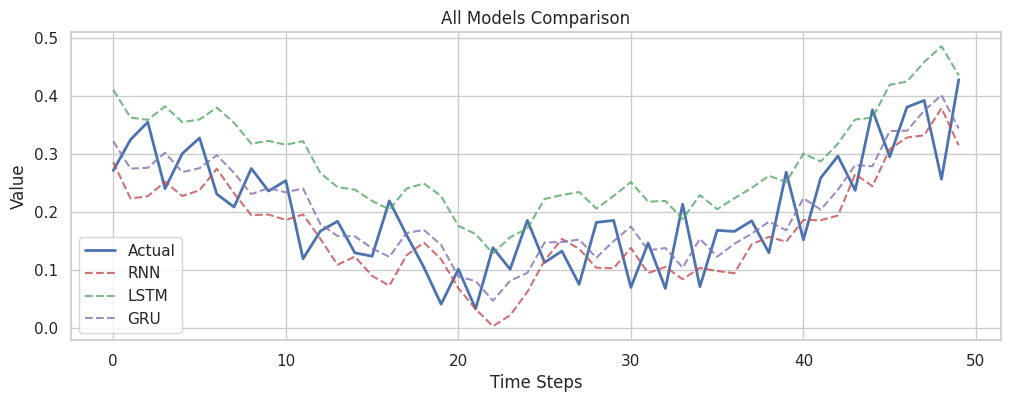

In [130]:
plt.figure(figsize=(12, 4))
plt.plot(y_actual[:n_points], 'b-', label='Actual', linewidth=2)
plt.plot(rnn_pred[:n_points], 'r--', label='RNN', alpha=0.8)
plt.plot(lstm_pred[:n_points], 'g--', label='LSTM', alpha=0.8)
plt.plot(gru_pred[:n_points], 'm--', label='GRU', alpha=0.8)
plt.title('All Models Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [131]:
def multi_step_prediction(model, initial_sequence, n_steps, scaler):
    model.eval()
    predictions = []
    
    if len(initial_sequence.shape) > 1:
        current_seq = initial_sequence.squeeze()
    else:
        current_seq = initial_sequence.clone()
    
    with torch.no_grad():
        for _ in range(n_steps):
            # Reshape for model input: (1, seq_length, 1)
            model_input = current_seq.unsqueeze(0).unsqueeze(-1)
            
            pred = model(model_input)
            pred_value = pred.squeeze().item()
            predictions.append(pred_value)
            
            current_seq = torch.cat([current_seq[1:], torch.tensor([pred_value])])
    
    return np.array(predictions)

In [132]:
test_sequence = X_test_tensor[0].squeeze() 
n_future_steps = 15


In [133]:
rnn_future = multi_step_prediction(rnn_model, test_sequence, n_future_steps, scaler)
lstm_future = multi_step_prediction(lstm_model, test_sequence, n_future_steps, scaler)
gru_future = multi_step_prediction(gru_model, test_sequence, n_future_steps, scaler)


In [134]:
historical_data = scaler.inverse_transform(test_sequence.numpy().reshape(-1, 1)).flatten()
rnn_future_actual = scaler.inverse_transform(rnn_future.reshape(-1, 1)).flatten()
lstm_future_actual = scaler.inverse_transform(lstm_future.reshape(-1, 1)).flatten()
gru_future_actual = scaler.inverse_transform(gru_future.reshape(-1, 1)).flatten()


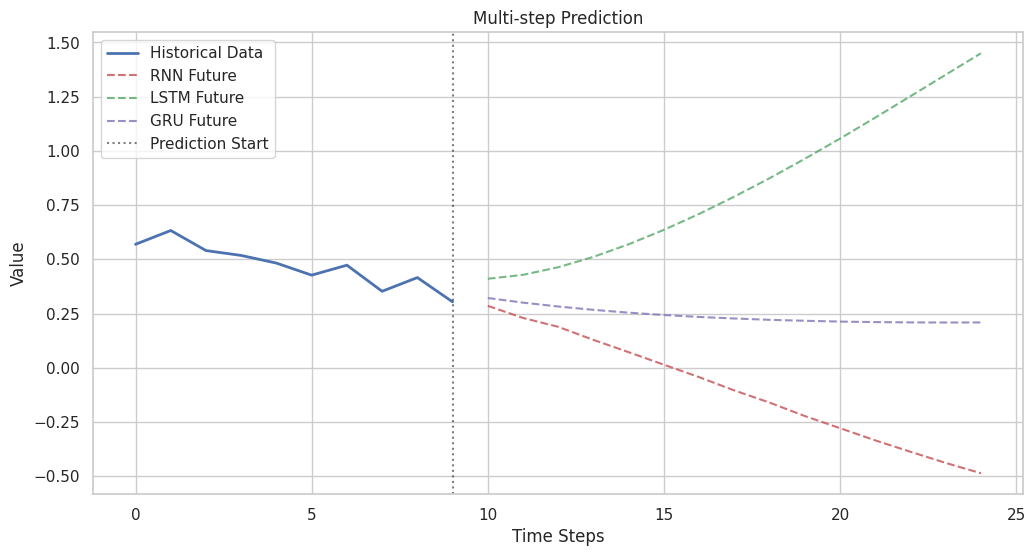

In [135]:
plt.figure(figsize=(12, 6))
historical_steps = range(len(historical_data))
future_steps = range(len(historical_data), len(historical_data) + n_future_steps)

plt.plot(historical_steps, historical_data, 'b-', label='Historical Data', linewidth=2)
plt.plot(future_steps, rnn_future_actual, 'r--', label='RNN Future', alpha=0.8)
plt.plot(future_steps, lstm_future_actual, 'g--', label='LSTM Future', alpha=0.8)
plt.plot(future_steps, gru_future_actual, 'm--', label='GRU Future', alpha=0.8)

plt.axvline(x=len(historical_data)-1, color='black', linestyle=':', alpha=0.5, label='Prediction Start')
plt.title('Multi-step Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
